In [123]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of Zn_peak_integration_lmfit_1degree_bg_7peaksTCcal_APS failed: Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\ProgramData\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\ProgramData\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\yifan

data process for 2023 APS Mar beamline data 

7 peaks are used to calculate TC: 002, 100, 102, 103, 110, 112, 201 

plot 4 peak TC: 002,100,102,103

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
import Zn_peak_integration_lmfit_1degree_bg_7peaksTCcal_APS as XRD_lmfit 
import time
import re
from datetime import datetime
import datetime
from tqdm import tqdm

In [125]:
def import_file(file_path, file): 

     filename = file_path + '\\' + file 

     dataframe=pd.read_csv(filename)

     return dataframe


In [126]:
def fitting_7_peaks(dataframe, intervals): 
     # intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]
     # 002, 100, 102, 103-110, 112, 201 

     hint = [{'background_c0':9525 , 'background_c1':-938, 'amplitude':2018, 
               'center':5.583, 'sigma':0.013, 'fraction':0.35},
                                        
               {'background_c0':5130 , 'background_c1':-171, 'amplitude':15000, 
               'center':5.982, 'sigma':0.012, 'fraction':0.23},

               {'background_c0':6719 , 'background_c1':-505, 'amplitude':5692, 
               'center':8.183, 'sigma':0.012, 'fraction':0.27},

               {'background_c0':3544 , 'background_c1':-127, 'amplitude1':3438,'center1':10.30,'sigma1':0.015,
               'fraction1':0.65, 'amplitude2':7841, 'center2':10.37, 'sigma2':0.01,  'fraction2':0.36},

               {'background_c0':3908 , 'background_c1':-158, 'amplitude':8464,
               'center':11.785,'sigma':0.015,'fraction':0.28},
               
               {'background_c0':4250 , 'background_c1':-190, 'amplitude':6280, 
               'center':12.305, 'sigma':0.015, 'fraction':0.285},
               
               ]
     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = XRD_lmfit.peak_intensities_lmfit(dataframe, intervals, hint)

     return df_params_all,df_best_fits_all, df_differences_all, df_integrals_all

In [127]:
# plot fiting result of each XRD pattern of in situ data 

def plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits,df_differences): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

    for i in tqdm(range(1,dataframe.shape[1])): 
        j=dataframe.shape[1]-i
        fig=plt.figure(figsize=(15,10))
        ax=fig.add_subplot(111)
        title=list(dataframe.columns.values)[i].split('obs_')[1].split('_primary')[0]
        plt.title(title, fontsize=15)
        plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,i],linewidth=3)
        plt.xlim(3.5,12.5)
        for (start, stop) in intervals: 
            x=df_best_fits.iloc[:,0]
            xx=x[(start<=x) == (x<=stop)]
            y_simulation=df_best_fits
            yy_simulation=y_simulation[(start<=x) == (x<=stop)].iloc[:,j]
            y_difference=df_differences
            yy_difference=y_difference[(start<=x) == (x<=stop)].iloc[:,j]

            
            plt.plot(xx,yy_simulation,label='simulation',linewidth=2)
            plt.plot(xx,yy_difference,label='difference',linewidth=2)

            plt.legend()

        plt.savefig(file_path + '\\lmfit_1degree_bg_7hkl_1nelder_formula2area_reverse' +'\\lmfit_1degree_bg_7hkl_' + title + timestr + '.png', dpi=300)
        # plt.savefig(file_path + '\\lmfit_1degree_bg_' + title + timestr + '.svg', dpi=300, format='SVG')
        plt.close()


In [128]:
# extract deposition time from pattern name 

def extract_depo_time(file_path_meta,start_depo): 

     #start_depo=datetime.datetime(2023,2,24,7,7,49)

     # time_change = datetime.timedelta(minutes=2,seconds=5)

     # start_depo_real= start_depo-time_change

     time_series=XRD_lmfit.extract_time_abs(file_path_meta,start_depo)
     print(time_series)

     return time_series

In [129]:
# join deoisition time and integrals, and plot time_integrals figure and save plot

def join_time_integrals_plot(time_series,df_integrals,file_path,file): 

      
     #time_integrals=pd.merge(left,right,left_index=True,right_index=True,how="left")
     
     time_integrals = pd.merge(time_series,df_integrals,how="inner", on="image_num")
     
     print(time_integrals)
     time_integrals.columns = ['image_num','Time/min', "002 peak", 
                              "100 peak", "102 peak", "103 peak", "110 peak", 
                              "112 peak", "201 peak", 
                              ]    

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     title='PeakArea_lmfit_' + file.split('.csv')[0] + timestr 
     plt.title(title, fontsize=10)
     # 002, 100, 102, 103-110, 112-200, 201 
     plt.scatter(time_integrals["Time/min"], time_integrals["002 peak"], label='002')
     plt.scatter(time_integrals["Time/min"], time_integrals["100 peak"], label='100')
     plt.scatter(time_integrals["Time/min"], time_integrals["102 peak"], label='102')
     plt.scatter(time_integrals["Time/min"], time_integrals["103 peak"], label='103')
     plt.scatter(time_integrals["Time/min"], time_integrals["110 peak"], label='110')
     plt.scatter(time_integrals["Time/min"], time_integrals["112 peak"], label='112')
     plt.scatter(time_integrals["Time/min"], time_integrals["201 peak"], label='201')


     plt.xlabel('Time/min',fontsize=12)
     plt.ylabel('Peak Area',fontsize=12)

     # plt.xlim(0,21)
     # plt.ylim(-10,2750)

     plt.legend()

     plt.savefig(file_path + '\\PeakArea_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

     return time_integrals 


In [130]:

#simulated_Zn = [1, 0.6262055, 2.83950711, 0.48685383]

def calculate_all_TC(time_integrals): 

     simulated_Zn = {"(002)": 1, "(100)": 0.623002, "(101)": 2.822881, "(102)": 0.481876, "(103)": 0.647973, 
                    "(110)": 0.424383, "(004)": 0.103752, "(112)": 0.510745, "(200)": 0.058331, "(201)": 0.318444,
                    "(104)": 0.092161, "(202)": 0.077218, "(203)": 0.145904, "(105)": 0.121085, "(114)": 0.157887,
                    "(210)": 0.032774,"(211)": 0.185132,"(204)": 0.0272}


     time_integrals_TC = XRD_lmfit.calculate_TC(time_integrals, simulated_Zn)

     return time_integrals_TC



In [131]:

def plot_time_TC(time_integrals_TC,file_path,file): 

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
     
     title='PeakArea_lmfit_7hkl_' + file.split('.csv')[0] + timestr 

     integrals=time_integrals_TC

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     plt.xlabel('Time/min',fontsize=12)
     ax.tick_params(width=2)
     for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(2)

     plt.ylabel('Texture Coefficient',fontsize=16)
     plt.xticks(fontsize=12)
     plt.yticks(fontsize=12)
     ax.set_ylim([0,2])

     plt.plot(integrals["Time/min"],(integrals["002 peak_TC"]),'o',label='002 TC')
     plt.plot(integrals["Time/min"],(integrals["100 peak_TC"]),'o',label='100 TC')
     plt.plot(integrals["Time/min"],(integrals["102 peak_TC"]),'o',label='102 TC')
     plt.plot(integrals["Time/min"],(integrals["103 peak_TC"]),'o',label='103 TC')
     # plt.plot(integrals["Time/min"],(integrals["110 peak_TC"]),'o',label='110 TC')
     # plt.plot(integrals["Time/min"],(integrals["112 peak_TC"]),'o',label='112 TC')
     # plt.plot(integrals["Time/min"],(integrals["201 peak_TC"]),'o',label='201 TC') 

     plt.legend(ncol=2,markerscale=2,frameon=False,fontsize=16)
     fig.suptitle(title, fontsize=12)
     plt.tight_layout()

     # plt.xlim(0,21)
     plt.ylim(0,2)
     plt.legend(loc='lower right')
     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig.savefig(file_path + '\\TC_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

In [132]:
# save fitting results 
def save_all_data(time_integrals_TC,df_best_fits,df_differences,df_params,file_path,file): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
    with pd.ExcelWriter(file_path + '\\' + 'lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.xlsx') as writer:
    
        # use to_excel function and specify the sheet_name and index
        # to store the dataframe in specified sheet
        time_integrals_TC.to_excel(writer, sheet_name="time_integrals_TC", float_format='%.5f',index=False)
        df_best_fits.to_excel(writer, sheet_name="best_fits", float_format='%.5f',index=False)
        df_differences.to_excel(writer, sheet_name="differences", float_format='%.5f',index=False)
        df_params.to_excel(writer, sheet_name="params", float_format='%.5f',index=False)

In [133]:
def do_all(file_path, file, start_depo, intervals):

     file_path_meta=file_path + '\\meta'
    
     dataframe=import_file(file_path, file)

     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = fitting_7_peaks(dataframe, intervals)

     print('\n')
     print('start plotting/saving fitted XRD curves')

     plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits_all,df_differences_all)

     print(df_integrals_all)

     time_series = extract_depo_time(file_path_meta,start_depo)

     print(time_series)

     time_integrals = join_time_integrals_plot(time_series,df_integrals_all,file_path,file)

     print(time_integrals)

     time_integrals_TC = calculate_all_TC(time_integrals)

     plot_time_TC(time_integrals_TC,file_path,file) 

     save_all_data(time_integrals_TC,df_best_fits_all,df_differences_all,df_params_all,file_path,file)

     print('\n')
     print('Done! All results saved! ^^')

start extracting image_num:


100%|██████████| 148/148 [00:00<00:00, 148364.48it/s]




start fitting XRD curves:


100%|██████████| 147/147 [00:44<00:00,  3.32it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 147/147 [01:08<00:00,  2.15it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 147/147 [01:29<00:00,  1.64it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 147/147 [01:32<00:00,  1.59it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 147/147 [02:17<00:00,  1.07it/s]


fitted interval:  [11.6, 11.905]


100%|██████████| 147/147 [01:10<00:00,  2.10it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 147/147 [02:09<00:00,  1.14it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  2.344473e-02  2.552363e-02  7.010965e-10     1.792143e-08   
1            1  3.385289e-02  8.260644e-03  3.139431e-03     1.792143e-08   
2            2  1.406127e-02  3.583447e-10  1.407273e-02     1.792143e-08   
3            3  8.380040e-09  4.769384e-09  1.253319e-02     1.792143e-08   
4            4  9.107539e-09  1.350003e-09  1.881739e-08     1.334211e-17   
..         ...           ...           ...           ...              ...   
142        142  3.227338e+01  5.512669e+02  1.917753e+02     1.127801e+02   
143        143  3.236868e+01  5.523604e+02  1.922497e+02     1.127801e+02   
144        144  3.248282e+01  5.523604e+02  1.924654e+02     1.127801e+02   
145        145  3.265247e+01  5.523604e+02  1.923399e+02     1.127801e+02   
146        146  3.265465e+01  5.523604e+02  1.923399e+02     1.127801e+02   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0       7.531097e-13

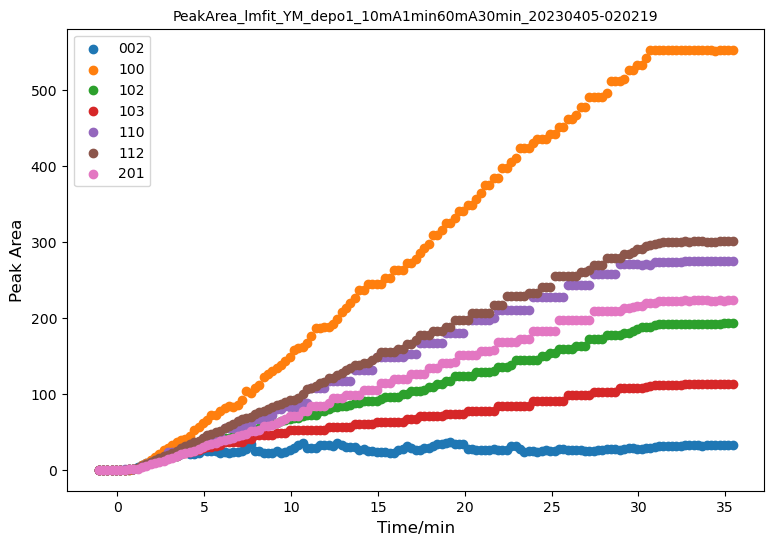

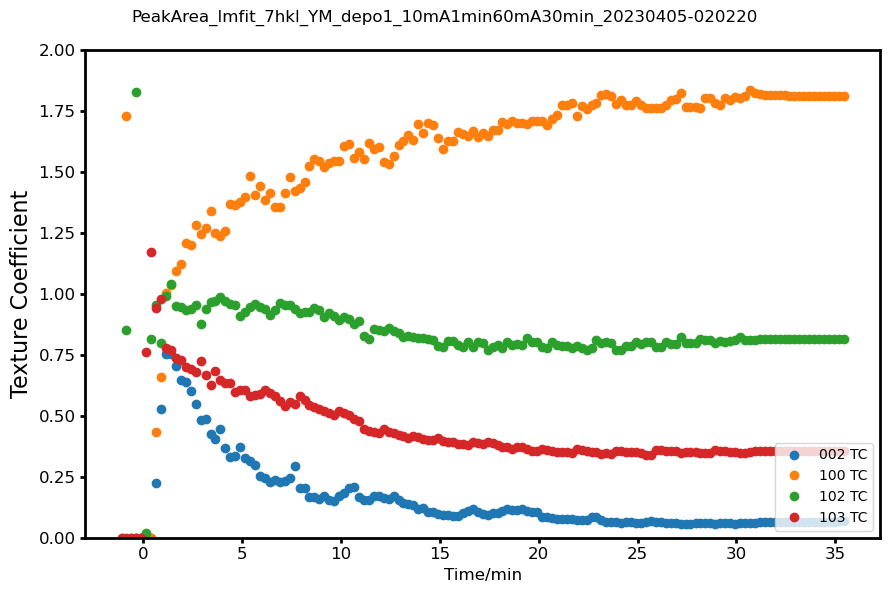

In [134]:
file_path=r'G:\APS2023Mar\YM_depo1_10mA1min60mA30min'

file=r'YM_depo1_10mA1min60mA30min.csv'

start_depo='03/14/2023 10:01:00 PM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)





start extracting image_num:


100%|██████████| 219/219 [00:00<00:00, 109769.67it/s]




start fitting XRD curves:


100%|██████████| 218/218 [02:58<00:00,  1.22it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 218/218 [02:07<00:00,  1.71it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 218/218 [03:12<00:00,  1.13it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 218/218 [03:24<00:00,  1.07it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 218/218 [03:57<00:00,  1.09s/it]


fitted interval:  [11.6, 11.905]


100%|██████████| 218/218 [02:55<00:00,  1.24it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 218/218 [02:55<00:00,  1.24it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  4.252268e-08  6.241978e-10  4.069160e-08     3.421777e-07   
1            1  4.841320e-07  3.772758e-08  8.185143e-09     3.825548e-03   
2            2  2.632575e-08  7.056774e-10  3.927620e-09     5.040856e-18   
3            3  2.521701e-08  2.130086e-07  4.500765e-07     3.913734e-02   
4            4  3.985490e-07  9.380801e-02  1.691558e-01     2.728324e-01   
..         ...           ...           ...           ...              ...   
213        213  8.448493e+01  6.979310e+01  5.553832e+01     5.717509e+01   
214        214  8.756279e+01  6.979310e+01  5.553832e+01     5.717509e+01   
215        215  8.756279e+01  6.979310e+01  5.553832e+01     5.717509e+01   
216        216  8.756279e+01  7.029763e+01  5.574963e+01     5.516510e+01   
217        217  8.756279e+01  7.126213e+01  5.528691e+01     5.029442e+01   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0       1.469891e-01

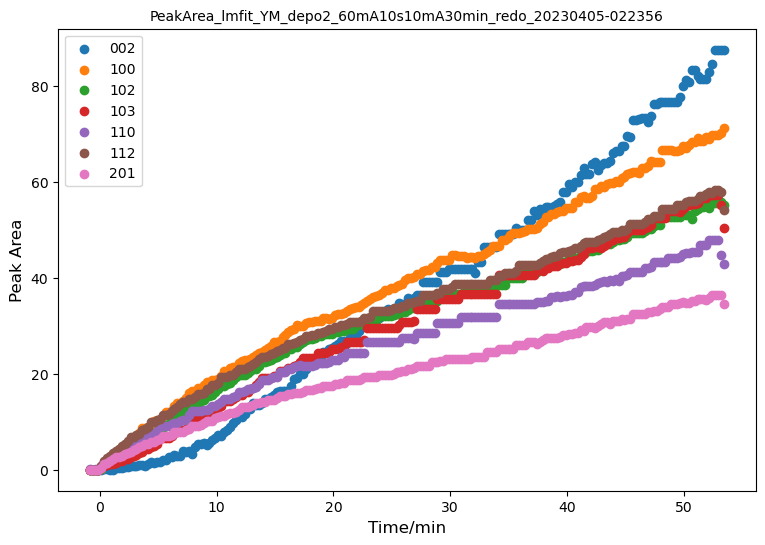

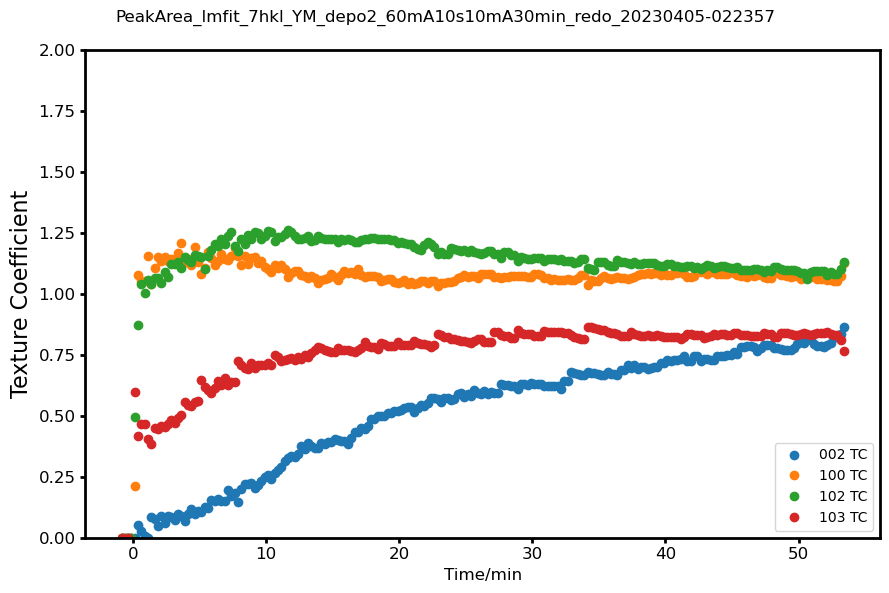

In [135]:
file_path=r'G:\APS2023Mar\YM_depo2_redo'

file=r'YM_depo2_60mA10s10mA30min_redo.csv'

start_depo='03/15/2023 9:09:30 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)


start extracting image_num:


100%|██████████| 209/209 [00:00<00:00, 209564.79it/s]




start fitting XRD curves:


100%|██████████| 208/208 [02:09<00:00,  1.61it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 208/208 [00:53<00:00,  3.88it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 208/208 [03:14<00:00,  1.07it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 208/208 [03:05<00:00,  1.12it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 208/208 [04:21<00:00,  1.26s/it]


fitted interval:  [11.6, 11.905]


100%|██████████| 208/208 [02:16<00:00,  1.52it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 208/208 [02:43<00:00,  1.27it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  6.401990e-11  7.988144e-10  9.875406e-08     9.642179e-17   
1            1  2.191088e-08  5.605536e-11  2.421597e-08     4.045151e-02   
2            2  2.942166e-09  4.226131e-08  7.738623e-08     3.444234e-02   
3            3  4.566524e-10  7.939665e-10  1.253314e-02     3.153968e-02   
4            4  6.017936e-08  1.174642e-09  6.892065e-11     8.032493e-02   
..         ...           ...           ...           ...              ...   
203        203  2.347211e+02  7.098314e+02  2.932857e+02     2.286960e+02   
204        204  2.347211e+02  7.143199e+02  2.932857e+02     2.286960e+02   
205        205  2.347211e+02  7.111845e+02  2.932857e+02     2.269164e+02   
206        206  2.347211e+02  7.113839e+02  2.932857e+02     2.276910e+02   
207        207  2.347211e+02  7.122487e+02  2.932857e+02     2.276910e+02   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0           0.198495

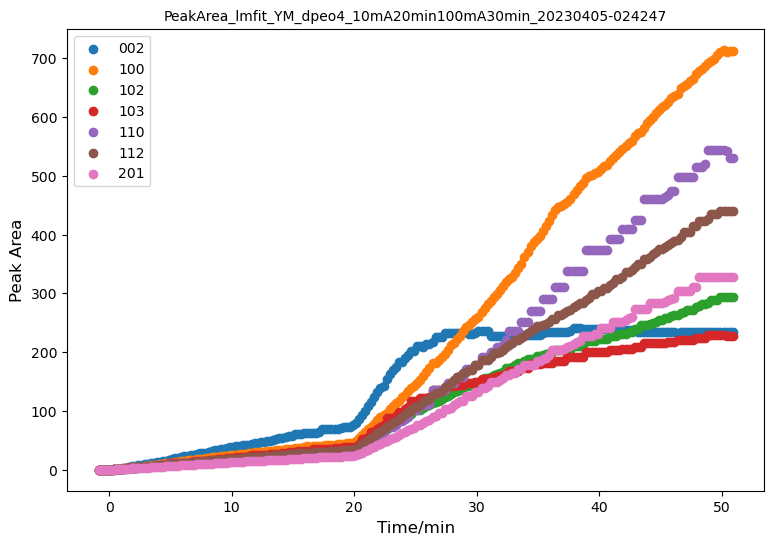

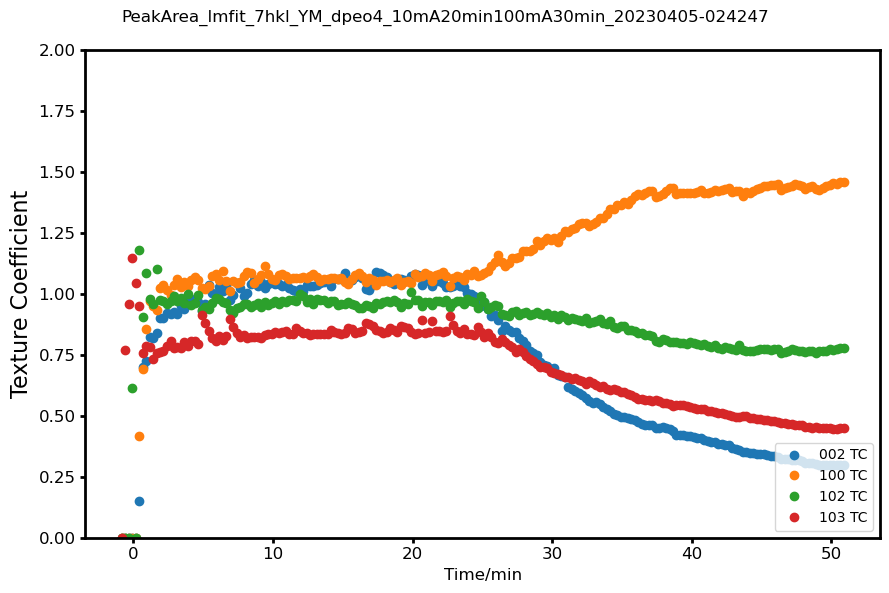

In [136]:
file_path=r'G:\APS2023Mar\YM_dpeo4_10mA20min100mA30min'

file=r'YM_dpeo4_10mA20min100mA30min.csv'

start_depo='03/15/2023 11:27:46 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)

start extracting image_num:


100%|██████████| 246/246 [00:00<00:00, 246488.00it/s]




start fitting XRD curves:


100%|██████████| 245/245 [02:20<00:00,  1.75it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 245/245 [02:46<00:00,  1.48it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 245/245 [03:00<00:00,  1.35it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 245/245 [03:08<00:00,  1.30it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 245/245 [04:29<00:00,  1.10s/it]


fitted interval:  [11.6, 11.905]


100%|██████████| 245/245 [02:37<00:00,  1.56it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 245/245 [03:11<00:00,  1.28it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]  [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  6.854019e-09  1.740384e-07     0.000018         0.016234   
1            1  9.464128e-10  1.105988e-07     0.014646         0.042769   
2            2  4.008766e-09  2.227486e-10     0.001058         0.039391   
3            3  2.383141e-09  2.373619e-08     0.001552         0.000715   
4            4  1.996376e-08  3.147609e-07     0.039209         0.162607   
..         ...           ...           ...          ...              ...   
240        240  5.821274e+02  3.905720e+02   272.100601       318.129393   
241        241  5.821274e+02  3.905720e+02   272.100601       317.994078   
242        242  5.821274e+02  3.908751e+02   272.655090       314.396719   
243        243  5.821274e+02  3.984927e+02   276.740382       314.396719   
244        244  5.821274e+02  3.984927e+02   276.740382       314.396719   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0           0.180815        0.03

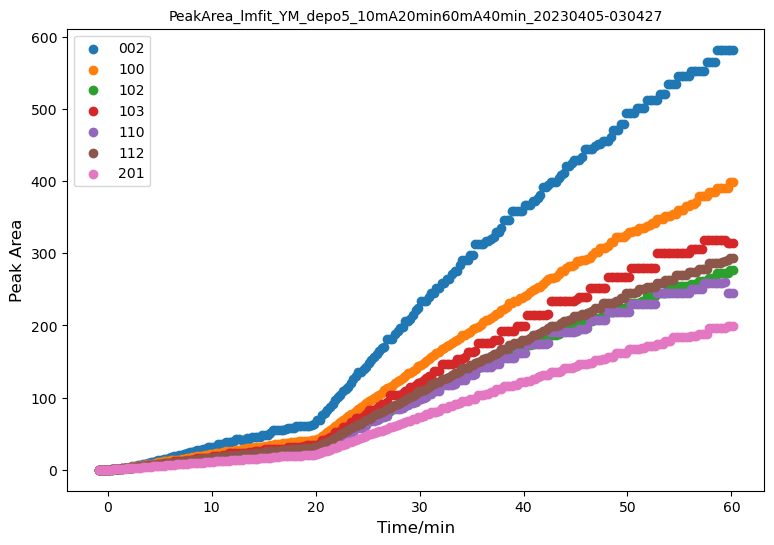

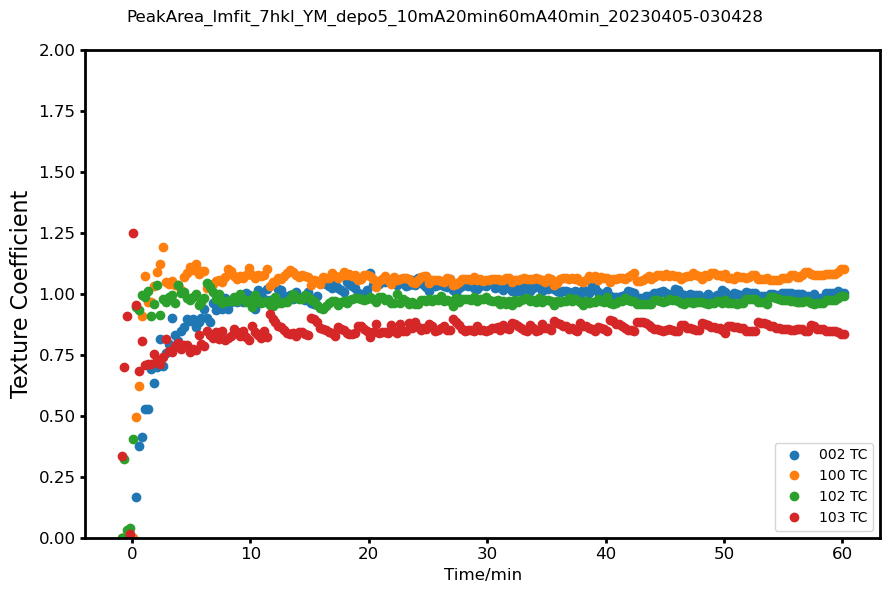

In [137]:
file_path=r'G:\APS2023Mar\YM_depo5_10mA20min60mA40min'

file=r'YM_depo5_10mA20min60mA40min.csv'

start_depo='03/15/2023 12:37:12 PM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)

start extracting image_num:


100%|██████████| 120/120 [00:00<00:00, 120295.53it/s]




start fitting XRD curves:


100%|██████████| 119/119 [01:04<00:00,  1.85it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 119/119 [00:11<00:00,  9.92it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


fitted interval:  [8.0, 8.35]


100%|██████████| 119/119 [01:50<00:00,  1.08it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 119/119 [02:02<00:00,  1.03s/it]


fitted interval:  [11.6, 11.905]


100%|██████████| 119/119 [00:41<00:00,  2.83it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 119/119 [01:34<00:00,  1.25it/s]


     image_num  [5.46, 5.71]  [5.8, 6.2]  [8.0, 8.35]  [10.05, 10.6]_1  \
0            0      0.167821    0.330732     0.267462         0.312750   
1            1      0.249892    0.342231     0.255947         0.383606   
2            2      1.565579    3.933385     2.363117         1.755884   
3            3      1.836540    7.675861     4.287383         3.028838   
4            4      1.948920   12.463715     6.509887         4.277521   
..         ...           ...         ...          ...              ...   
114        114      1.470550   87.346811    30.275389        14.654709   
115        115      1.582688   88.482371    30.121558        14.417800   
116        116      1.532534   89.133068    30.155017        14.199046   
117        117      1.680767   89.050847    30.532035        14.500042   
118        118      1.860128   89.001987    30.810501        13.675212   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0           0.516633        0.549948        0.314432  
1

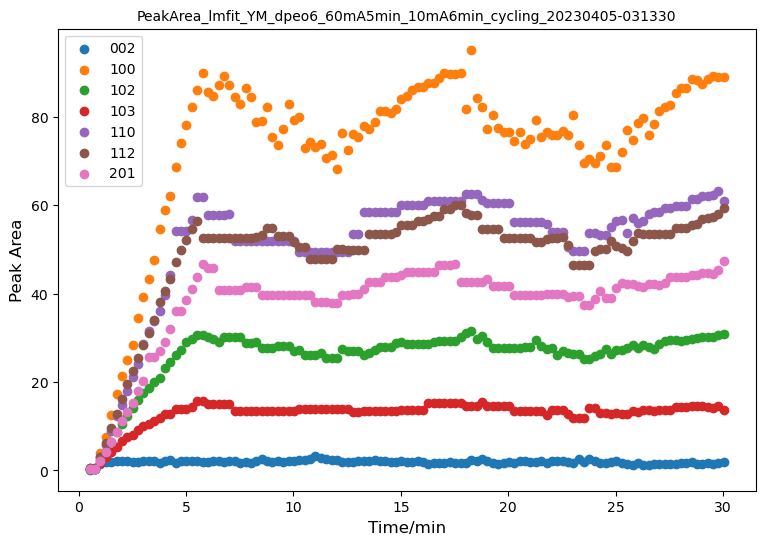

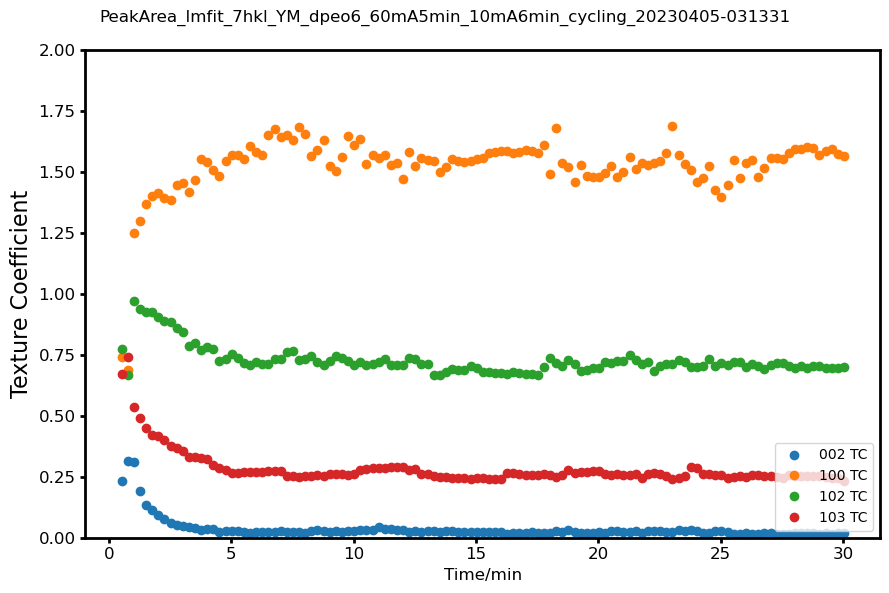

In [138]:
file_path=r'G:\APS2023Mar\YM_dpeo6_60mA5min_10mA1min_cycling'

file=r'YM_dpeo6_60mA5min_10mA6min_cycling.csv'

start_depo='03/15/2023 2:41:13 PM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)

start extracting image_num:


100%|██████████| 187/187 [00:00<00:00, 187281.48it/s]




start fitting XRD curves:


100%|██████████| 186/186 [00:57<00:00,  3.21it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 186/186 [00:06<00:00, 30.78it/s] 


fitted interval:  [5.8, 6.2]


100%|██████████| 186/186 [00:08<00:00, 20.88it/s] 


fitted interval:  [8.0, 8.35]


100%|██████████| 186/186 [00:10<00:00, 18.37it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 186/186 [00:10<00:00, 18.23it/s]


fitted interval:  [11.6, 11.905]


100%|██████████| 186/186 [00:09<00:00, 19.44it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 186/186 [02:21<00:00,  1.32it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  1.238390e-10  5.860805e-12  1.641617e-02         0.019179   
1            1  1.667570e-08  1.094049e-07  1.528310e-09         0.055470   
2            2  2.720390e-08  1.761171e-08  4.501830e-10         0.065030   
3            3  1.253178e-02  3.821389e-05  7.047200e-02         0.019532   
4            4  2.468599e-08  1.644946e-01  3.656252e-02         0.104457   
..         ...           ...           ...           ...              ...   
181        181  2.084134e+01  4.370468e+01  1.930006e+01        14.764560   
182        182  2.157106e+01  4.477447e+01  1.926485e+01        15.130980   
183        183  2.179879e+01  4.345485e+01  1.924702e+01        15.014221   
184        184  2.094295e+01  4.324730e+01  1.959626e+01        15.647372   
185        185  2.066752e+01  4.356244e+01  1.991807e+01        15.154524   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0           0.074776

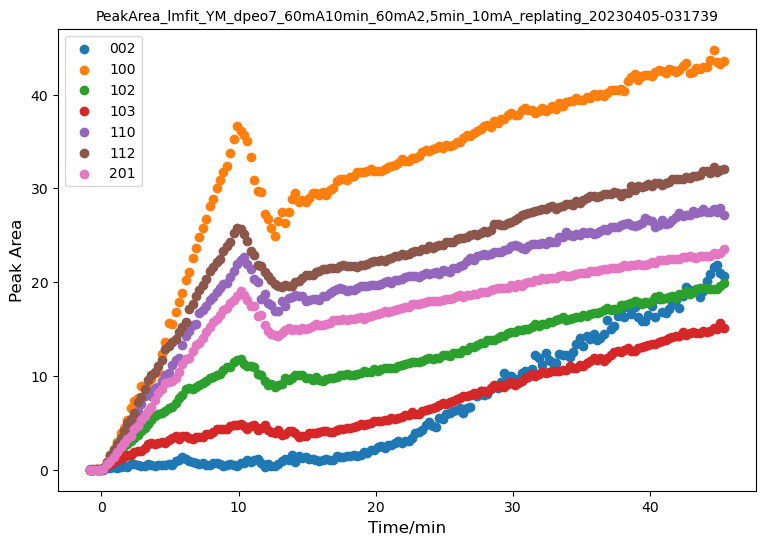

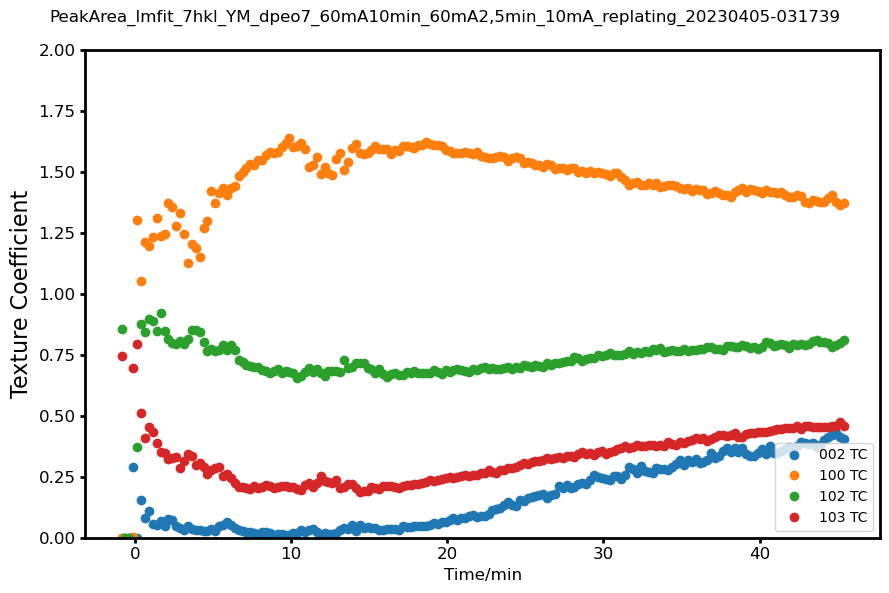

In [139]:
file_path=r'G:\APS2023Mar\YM_depo7'

file=r'YM_dpeo7_60mA10min_60mA2,5min_10mA_replating.csv'

start_depo='03/16/2023 7:43:24 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)

start extracting image_num:


100%|██████████| 226/226 [00:00<00:00, 226610.73it/s]




start fitting XRD curves:


100%|██████████| 225/225 [00:49<00:00,  4.51it/s]


fitted interval:  [5.46, 5.71]


100%|██████████| 225/225 [00:08<00:00, 27.67it/s]


fitted interval:  [5.8, 6.2]


100%|██████████| 225/225 [00:08<00:00, 25.11it/s] 


fitted interval:  [8.0, 8.35]


100%|██████████| 225/225 [00:16<00:00, 13.77it/s]


fitted interval:  [10.05, 10.6]


100%|██████████| 225/225 [00:12<00:00, 18.36it/s]


fitted interval:  [11.6, 11.905]


100%|██████████| 225/225 [00:04<00:00, 50.86it/s]


fitted interval:  [12.15, 12.48]


start plotting/saving fitted XRD curves


100%|██████████| 225/225 [02:58<00:00,  1.26it/s]


     image_num  [5.46, 5.71]    [5.8, 6.2]   [8.0, 8.35]  [10.05, 10.6]_1  \
0            0  3.299771e-10  1.542069e-09  9.851720e-09     1.723489e-02   
1            1  1.109617e-07  3.401216e-11  1.435200e-09     3.462235e-07   
2            2  3.931533e-03  1.624993e-09  2.630931e-08     6.552864e-03   
3            3  2.345061e-02  2.761831e-10  2.001148e-10     5.167486e-03   
4            4  3.271434e-02  3.843526e-02  8.334643e-13     3.396053e-02   
..         ...           ...           ...           ...              ...   
220        220  4.549198e+00  1.427640e+01  7.124058e+00     6.182269e+00   
221        221  4.806207e+00  1.478358e+01  7.183956e+00     6.230351e+00   
222        222  4.554136e+00  1.351015e+01  7.046863e+00     6.098745e+00   
223        223  4.385434e+00  1.401056e+01  7.123102e+00     5.735950e+00   
224        224  4.411266e+00  1.381760e+01  7.309193e+00     5.117217e+00   

     [10.05, 10.6]_2  [11.6, 11.905]  [12.15, 12.48]  
0           0.045972

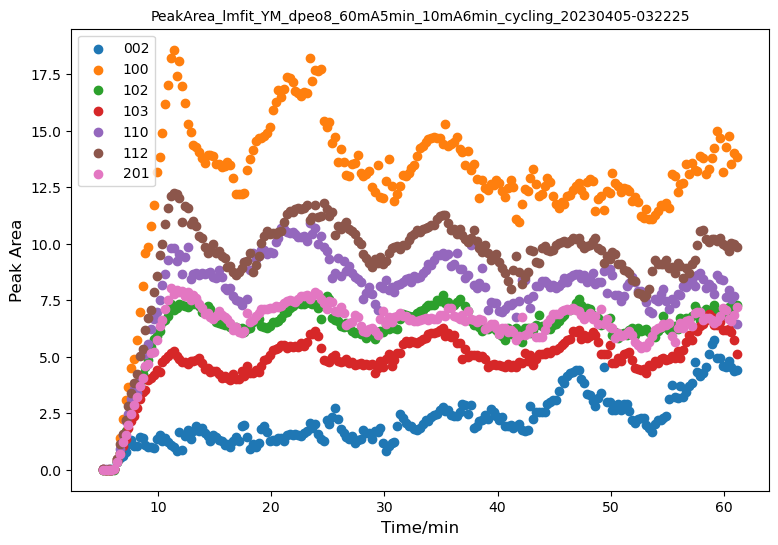

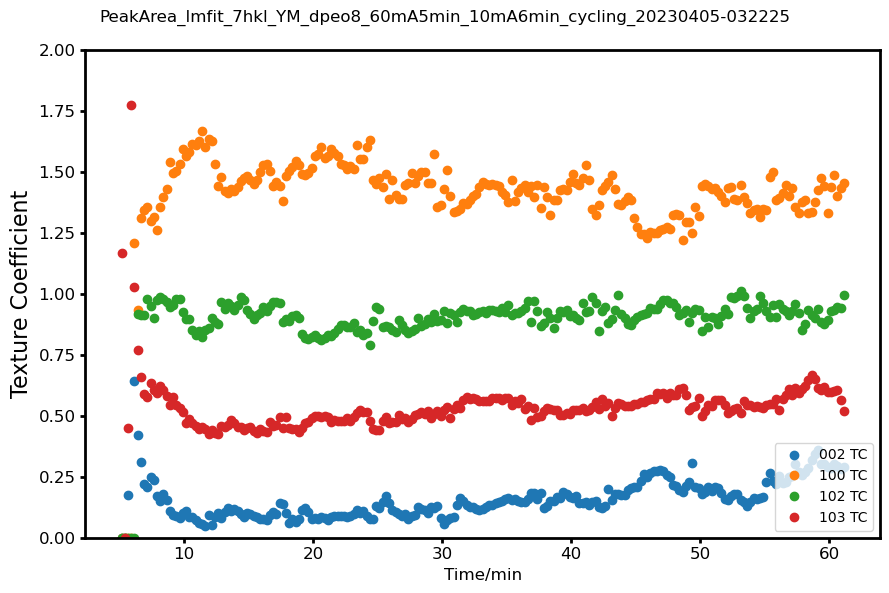

In [140]:
file_path=r'G:\APS2023Mar\YM_dpeo8'

file=r'YM_dpeo8_60mA5min_10mA6min_cycling.csv'

start_depo='03/16/2023 8:44:39 AM'

intervals= [(5.46,5.71), (5.8,6.2), (8.0,8.35), (10.05,10.6),(11.6,11.905),(12.15,12.48)]

# 002, 100, 102, 103-110, 112, 201 

do_all(file_path, file, start_depo, intervals)